# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import requests # Импортируем библиотеку requests
import category_encoders as ce
from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

from math import log

# Чтение данных

In [7]:
hotels = pd.read_csv('./data/hotels.csv')
hotels.head(3)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [11]:
hotels.describe(include='all')

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
count,386803,386803.000000,386803,386803.000000,386803,386803,386803,386803.000000,386803.000000,386803,386803.000000,386803.00000,386803.000000,386803,386803,384355.000000,384355.000000
unique,1493,NaN,731,NaN,1492,225,248828,NaN,NaN,311737,NaN,NaN,NaN,47135,731,NaN,NaN
top,163 Marsh Wall Docklands Tower Hamlets London ...,NaN,8/2/2017,NaN,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,NaN,NaN,No Positive,NaN,NaN,NaN,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days,NaN,NaN
freq,3587,NaN,1911,NaN,3587,184033,95907,NaN,NaN,26885,NaN,NaN,NaN,3853,1911,NaN,NaN
mean,NaN,498.246536,NaN,8.397231,NaN,NaN,NaN,18.538988,2743.992042,NaN,17.776985,7.17725,8.396906,NaN,NaN,49.443522,2.823402
std,NaN,500.258012,NaN,0.547881,NaN,NaN,NaN,29.703369,2316.457018,NaN,21.726141,11.05442,1.636090,NaN,NaN,3.466936,4.579043
min,NaN,1.000000,NaN,5.200000,NaN,NaN,NaN,0.000000,43.000000,NaN,0.000000,1.00000,2.500000,NaN,NaN,41.328376,-0.369758
25%,NaN,169.000000,NaN,8.100000,NaN,NaN,NaN,2.000000,1161.000000,NaN,5.000000,1.00000,7.500000,NaN,NaN,48.214662,-0.143649
50%,NaN,342.000000,NaN,8.400000,NaN,NaN,NaN,9.000000,2134.000000,NaN,11.000000,3.00000,8.800000,NaN,NaN,51.499981,-0.000250
75%,NaN,660.000000,NaN,8.800000,NaN,NaN,NaN,23.000000,3613.000000,NaN,22.000000,8.00000,9.600000,NaN,NaN,51.516288,4.834443


# Удаляем дубликаты

In [8]:
dupl_columns = list(hotels.columns)

print(f'Число найденных дубликатов: {hotels.shape[0]}')

mask = hotels.duplicated( subset = dupl_columns )
hh_duplicates = hotels[mask]
print(f'Число найденных дубликатов: {hh_duplicates.shape[0]}')
#307

hotels.drop_duplicates(subset = dupl_columns, inplace = True)
print(f'Результирующее число записей: {hotels.shape[0]}')
#386496


Число найденных дубликатов: 386803
Число найденных дубликатов: 307
Результирующее число записей: 386496


# Анализируем пропуски

In [9]:
# Печатает поля с null признаками
def get_nulls_fiels(df):
    cols_null_percent = df.isnull().mean() * 100
    cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values( ascending = False )
    display(cols_with_null)
    
get_nulls_fiels( hotels )

lat    0.633383
lng    0.633383
dtype: float64

### Заполним медианным значением того города, в котором признак заполнен. Так не придется использовать geocoder

In [ ]:
# Выкусываем 2 последних слова.Это страна и город (с небольшим исключением, но для пропущенных данных справедливо)
hotels["town"] = hotels["hotel_address"].apply( lambda x: ' '.join( x.split()[-2:] ) )

# Колонки с null
col_null = ["lng", "lat"]

dict_col_not_null = dict()
for col in col_null:
    # Из строк с coll == null получим список стран и городов
    arr = hotels[hotels[col].isnull()].loc[:,"town"].unique()
    # Получим медианы найденных городов и стран с заполненными колонками
    dict_median = hotels[hotels['town'].isin(arr) & hotels[col].notnull()].groupby( ["town"] )[col].median().to_dict()
    print( f"Заполняю признак {col} == null медианой: {dict_median}" )
    hotels[col] = hotels.apply( lambda x: dict_median.get( x["town"] ) if pd.isnull( x[col] ) else x[col], axis=1 )

# Поле более не нужно
hotels.drop( "town", axis=1, inplace=True )

Заполняю признак lng == null медианой: {'Barcelona Spain': 2.1696699, 'Paris France': 2.328075, 'Vienna Austria': 16.3686397}
Заполняю признак lat == null медианой: {'Barcelona Spain': 41.388024, 'Paris France': 48.8671391, 'Vienna Austria': 48.2044655}


In [11]:
get_nulls_fiels( hotels )
# Пропусков нет

Series([], dtype: float64)

# Создаем/модифицируем признаки

### days_since_review

In [12]:
# Выкусываемчисло дней
hotels["days_since_review"] = hotels["days_since_review"].apply( lambda x: re.sub('[^0-9]', '', x )).astype(int)

### review_date

In [13]:
# Из строки дам создаем признаки дня, месяца и года
hotels['review_date'] =  pd.to_datetime(hotels['review_date'], dayfirst=False,yearfirst=False)
hotels["review_date_year"] = hotels["review_date"].dt.year
hotels["review_date_month"] = hotels["review_date"].dt.month
hotels["review_date_day"] = hotels["review_date"].dt.day
hotels['review_date'] =  hotels["review_date"].dt.year * 365 + hotels["review_date"].dt.month * 12 + hotels["review_date"].dt.day


<Axes: >

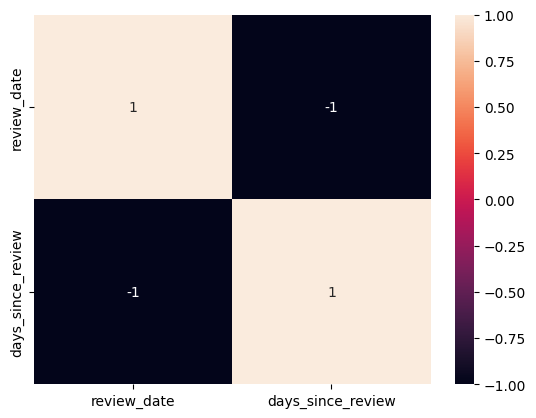

In [14]:
# Сразу проверим на корреляцию пару полей review_date (и производные) и days_since_review. По смыслу схожи
sns.heatmap(hotels[['review_date',"days_since_review"]].corr(numeric_only=True).round(1), annot=True)

In [15]:
# Удалим колонки. 3 признака из них мы уже создали
hotels.drop( ['review_date','days_since_review'], axis=1, inplace=True )

In [17]:
# Оценим плоцент уникальных полей
def get_percent_unique( df ):
    hotels.nunique() * 100 / hotels.shape[0]
    
get_percent_unique( hotels )

### hotel_name - Категориальный номинальный признак => Binary coding

In [18]:
cols = ['hotel_name']

bin_encoder = ce.BinaryEncoder(cols=cols) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels[cols])
hotels = pd.concat([hotels, type_bin], axis=1)

### Разбор признаков positive_review, negative_review. Используем меру tf-idf для оценки важности слова в контексте документа


In [19]:
# Чистим от спец знаков
hotels["positive_review"] = hotels["positive_review"].apply( lambda x: re.sub( r'[^a-zA-Z0-9а-яА-Я]', ' ', x ).strip().lower() + ' ' )
hotels["negative_review"] = hotels["negative_review"].apply( lambda x: re.sub( r'[^a-zA-Z0-9а-яА-Я]', ' ', x ).strip().lower() + ' ' )

# Группируем данные по отелям
df_grp_pos = hotels.groupby( "hotel_name" )["positive_review"].sum().reset_index()
df_grp_neg = hotels.groupby( "hotel_name" )["negative_review"].sum().reset_index()

### Функции для экономной версии tf-idf

In [21]:
#############################################################################################################
#
# Вход: Строка текста
# Выход: Список слов 3х и более знаков и не среди списка слов-исключений. Буквы на спец символы не проверяются
# Пример: 'There are apples where while and black.' ==> ['there', 'are', 'apples', 'while', 'black.']
#
#############################################################################################################
def parse_msg( msg ):
    # На всякий случай - исключим эти слова из рейтингов
    words_excl = [
        "the",
        "and",
        "was",
        "are",
        "where",
        "for"
    ]      
        
    # Возвращает True, если слово длинее 2х знаков и не в списке исключений
    def flt_words( x ):
        return len( x ) > 2 and x not in words_excl    
    
    words = filter( lambda x: flt_words( x ), msg.lower().split() )
    return list( filter( lambda x: x.strip() , words ) )


#############################################################################################################
# Возвращает число - суммарный каждого слова сообщения рейтинг по метрике tf-idf 
#
# Вход: Строка текста
#    msg - Строка текста
#    grp - Код группы, к которой относится сообщение
#    arr_df_idf - Список групп (пкз): в каждой из которых в вычисленный рейтинг слова по метрике tf-idf
#    dict_words_by_name - словарь слов, ключ - слово { "Слово 1": 0, "Слово 2": 1 }
#    dict_grp_by_name - словарь групп ключ - название группы { "Группа 1": 0, "Группа 2": 1 }
#
# Выход - Число, суммарный рейтинг сообщения 
# Пример: 
#
#############################################################################################################
def calc_rating_msg( msg, grp, arr_df_idf, dict_words_by_name, dict_grp_by_name ):
    words = parse_msg( msg )
    rating = 0
    for word in words:
        rating += arr_df_idf[dict_words_by_name[word][0]][dict_grp_by_name[grp][0]]         
    return rating


#############################################################################################################
# Создает справочники групп и слов 
#
# Вход: Строка текста
#    df - Датафрейм с сообщением
#    col_grp - Поле группы
#    col_text - Поле текста
#
# Выход - tuple с 4мя справочниками преобразований кода в слово или категорию и обратно (dict_words_by_name, dict_grp_by_name, dict_words_by_id, dict_grp_by_id)
#    
#    dict_words_by_name - Словарь отображения слова в tuple(идентификатор слова, количество повторений в полном датафрейме)
#    dict_grp_by_name - Словарь отображения названия группы в tuple(идентификатор групп, количество слов в группе)
#    dict_words_by_id - Словарь отображения идентификатора слова в слово: tuple(слово, количество повторений слов в датафрейме)
#    dict_grp_by_id - Словарь отображения идентификатора группы в название: tuple (название, количество слов в группе)
#    
#    
#############################################################################################################
def id_idf_make_dict( df, col_grp, col_text ):
    # Словарь слов
    dict_grp_by_name = {}
    dict_words_by_name = {}
    dict_grp_by_id = {}
    dict_words_by_id = {}
    ind_word = 0

    for index, row in df.iterrows():
        grp = row[col_grp] # Название группы

        # Получим список слов
        tmp_lst = parse_msg( row[col_text] )
        
        # Извлекаем слово из строки
        for word in tmp_lst:
            # Обновим частота слов по всем группам
            if word not in dict_words_by_name:
                dict_words_by_name[word] = (ind_word,1)
                dict_words_by_id[dict_words_by_name[word][0]] = (word,1)
            else:
                dict_words_by_name[word] = (dict_words_by_name[word][0], dict_words_by_name[word][1] + 1)  
                dict_words_by_id[dict_words_by_name[word][0]] = (dict_words_by_id[dict_words_by_name[word][0]][0], dict_words_by_id[dict_words_by_name[word][0]][1] + 1)
            
            ind_word = ind_word + 1
         
        # Количество слов в группе
        dict_grp_by_name[grp] = ( index, len( tmp_lst ) )
        dict_grp_by_id[index] = ( grp, len( tmp_lst ) )
        
    return (dict_words_by_name, dict_grp_by_name, dict_words_by_id, dict_grp_by_id)

#############################################################################################################
# Создает словарь идентавикаторов групп, содержащих словарь идентификаторов слов и количества повторений в группе
#
# Вход: Строка текста
#    df - Датафрейм с сообщением
#    col_grp - Поле группы
#    col_text - Поле текста
#    dict_цщкв_by_name - Словарь отображения слова в идентификаторы (кодирование) 
#    dict_grp_by_name - Словарь отображения групп в идентификаторы (кодирование) 
#    dict_word_by_id - Словарь отображения идентификаторов слов в слова (декодирование) 
#    dict_grp_by_id - Словарь отображения идентификатора группы в название (декодирование) 
#
# Выход: - словарь рейтингов с метрикой tf-idf
#    words_rating = { ИД слова: {ИД группы: рейтинг}}
#    
#############################################################################################################
def id_idf( df, col_grp, col_text, dict_words_by_name, dict_grp_by_name, dict_word_by_id, dict_grp_by_id ):
    print('---->> Старт')
    # Словарь слов
    dict_grp_words = {}
    dict_words_grp = {}
    words_rating = {}
    arr_grp = []
    cnt_groups = df.shape[0] # Экономим вычисления
    
    for index, row in df.iterrows():
        grp = row[col_grp] # Название группы
        grp_id = dict_grp_by_name[ grp ][0] # ID группы
        arr_grp.append( grp_id ) # По этим ключам будем считать tf-idf
        
        # Список слов в группе
        tmp_lst = list( map( lambda x: dict_words_by_name[x][0], parse_msg( row[col_text] )  ) )
        # Список уникальных слов в группе
        set_lst = list( set( tmp_lst ) )
        
        # Частота слов в группе (Nword,grp)
        tmp_word_in_groups = {}
        for word_id in set_lst:
            tmp_word_in_groups[word_id] = tmp_lst.count( word_id )

        dict_grp_words[grp_id] = tmp_word_in_groups
    
    # Подсчет количества групп, в которые входит слово { "Слово 1": 7, "Слово 2": 11, ...}
    for word_id in dict_word_by_id:
        for grp_id in dict_grp_words:
            # Обновим частоты слов по всем группам
            if word_id in dict_grp_words[grp_id]:
                if word_id not in dict_words_grp:
                    dict_words_grp[word_id] = 1
                else:
                    dict_words_grp[word_id] += 1  

    # Словарь расчетов df-idf
    for grp_id in arr_grp:
        for word_id in dict_grp_words[grp_id]:
            tf = dict_grp_words[grp_id][word_id] / dict_grp_by_id[grp_id][1]
            idf = cnt_groups / dict_words_grp[word_id]
            tf_idf = tf * log( idf )
            if word_id not in words_rating:
                words_rating[word_id] = {}
            words_rating[word_id][grp_id] = tf_idf
            #print( f"word_id = {word_id}, grp_id = {grp_id}, tf = {tf}, idf = {idf}, Nw = {dict_grp_words[grp_id][word_id]}, N = {dict_grp_by_id[grp_id][1]}, Ngw = {dict_words_grp[word_id]}, Ng = {dict_words_grp[word_id]}, tf_idf = {tf_idf} " )
            
    print('---->> Финиш')
    return words_rating

In [25]:
############################### Тестовый образец данных для проверки интегральной версии оценки tf-idf
#
d = {'col_msg': ["111 222 333 444 111","222 555 777"], 'col_grp': ["row1", "row2"]}
df_test = pd.DataFrame(data=d)

test_grp_by_name = {'row1': (1,5), 'row2':(2,3)}
test_grp_by_id = {1:('row1',5), 2:('row2',3)}
test_words_by_name = {'111':(0,1), '222':(1,2), '333':(2,1), '444':(3,1), '555':(4,1), '777':(6,1)}
test_words_by_id = {0:('111',1), 1:('222',2), 2:('333',1), 3:('444',1),4:('555',1),6:('777',1)}

rating_words = id_idf( df_test, "col_grp", "col_msg", test_words_by_name,test_grp_by_name,test_words_by_id,test_grp_by_id )
print( f"rating_words: {rating_words}" )


---->> Старт
---->> Финиш
rating_words: {0: {1: 0.2772588722239781}, 1: {1: 0.0, 2: 0.0}, 2: {1: 0.13862943611198905}, 3: {1: 0.13862943611198905}, 4: {2: 0.23104906018664842}, 6: {2: 0.23104906018664842}}


### Готовим словари

In [22]:
dict_words_by_name_pos, dict_grp_by_name_pos, dict_words_by_id_pos, dict_grp_by_id_pos = id_idf_make_dict( df_grp_pos, "hotel_name", "positive_review" )  
dict_words_by_name_neg, dict_grp_by_name_neg, dict_words_by_id_neg, dict_grp_by_id_neg = id_idf_make_dict( df_grp_neg, "hotel_name", "negative_review" )  

In [23]:
print( 'Вычисляем значимость слов из признака positive_review' )
rating_words_pos = id_idf( df_grp_pos, "hotel_name", "positive_review", dict_words_by_name_pos, dict_grp_by_name_pos, dict_words_by_id_pos, dict_grp_by_id_pos )

print()
print( 'Вычисляем значимость слов из признака negative_review' )
rating_words_neg = id_idf( df_grp_neg, "hotel_name", "negative_review", dict_words_by_name_neg, dict_grp_by_name_neg, dict_words_by_id_neg, dict_grp_by_id_neg )

print()
print( 'Добавляем рейтинги отзывов positive_review, negative_review' )
hotels["positive_review_rating"] = hotels.apply( lambda x: calc_rating_msg( x["positive_review"], x["hotel_name"], rating_words_pos, dict_words_by_name_pos, dict_grp_by_name_pos ), axis=1 )
hotels["negative_review_rating"] = hotels.apply( lambda x: calc_rating_msg( x["negative_review"], x["hotel_name"], rating_words_neg, dict_words_by_name_neg, dict_grp_by_name_neg ), axis=1 )

#hotels.drop( ['positive_review','negative_review'], axis=1, inplace=True ) 


Вычисляем значимость слов из признака positive_review
---->> Старт
---->> Финиш

Вычисляем значимость слов из признака negative_review
---->> Старт
---->> Финиш

Добавляем рейтинги отзывов positive_review, negative_review


### Добавим  top 10 слов из позитивной и негативной оценок

In [24]:
# top 10 слов
top_cnt = 10
words_add_pos = list( dict( sorted( dict_words_by_name_pos.items(), key = lambda x: x[1][1], reverse=True )[:top_cnt] ).keys() )
words_add_neg = list( dict( sorted( dict_words_by_name_neg.items(), key = lambda x: x[1][1], reverse=True )[:top_cnt] ).keys() )

list_add_words = [words_add_pos,words_add_neg]

for word in words_add_pos:
    hotels[word + '_pos'] = hotels["positive_review"].apply( lambda x: 1 if word in x else 0 )
    
for word in words_add_neg:
    hotels[word + '_neg'] = hotels["negative_review"].apply( lambda x: 1 if word in x else 0 )

print( "Добавлены поля" )
print( words_add_pos )
print( words_add_neg )

Добавлены поля
['staff', 'very', 'location', 'room', 'hotel', 'good', 'great', 'were', 'friendly', 'breakfast']
['room', 'negative', 'not', 'very', 'but', 'hotel', 'were', 'had', 'that', 'breakfast']


In [ ]:
# Проверим частоту (что заполнилось)
hotels[hotels["positive_review"].str.contains( words_add_pos[0])].shape[0]

141977

### Разбор признаков hotel_address

- Вытягиваем страны из признака и заносим в новый признак $country$
- Выкусываем страны из строки признака hotel_address

In [26]:
#https://geo.koltyrin.ru/eng_countries_of_the_world.php
#https://worldostats.com/countries/

def get_counryes():
    from bs4 import BeautifulSoup # Импортируем библиотеку BeautifulSoup

    url = 'https://worldostats.com/countries/' # Страница стран
    response = requests.get(url)  # Выполняем GET-запрос
    soup = BeautifulSoup(response.text, 'html.parser') # Создаём объект BeautifulSoup, указывая html-парсер

    countres = []

    lines = soup.find_all( 'td' ) # Таблицы стран
    for items in lines[ : ]: 
        item = items.find( 'a' ) # Затем до ячейки с тэгом <a>
        if item: # После 16 элемента идет не нужная нам информация
            countres.append( item.text ) # Сразу заключаем в одинарные ковычки город 
            
    return countres

def find_in_arr( s, lst ):
    for item in lst:
        if item in s:
            return item
    return ""
    
countres = get_counryes()  

# Новый признак
hotels["country"] = hotels["hotel_address"].apply( lambda x: find_in_arr( x, countres ) )
# Выкусываем страны
hotels["hotel_address"] = hotels.apply( lambda x: x["hotel_address"].replace( x["country"], '' ), axis=1 )

# Проверим, что все нормально
print( hotels[hotels["country"] == ""] )
print( hotels["country"].isnull().mean() )

Empty DataFrame
Columns: [hotel_address, additional_number_of_scoring, average_score, hotel_name, reviewer_nationality, negative_review, review_total_negative_word_counts, total_number_of_reviews, positive_review, review_total_positive_word_counts, total_number_of_reviews_reviewer_has_given, reviewer_score, tags, lat, lng, review_date_year, review_date_month, review_date_day, hotel_name_0, hotel_name_1, hotel_name_2, hotel_name_3, hotel_name_4, hotel_name_5, hotel_name_6, hotel_name_7, hotel_name_8, hotel_name_9, hotel_name_10, positive_review_rating, negative_review_rating, staff_pos, very_pos, location_pos, room_pos, hotel_pos, good_pos, great_pos, were_pos, friendly_pos, breakfast_pos, room_neg, negative_neg, not_neg, very_neg, but_neg, hotel_neg, were_neg, had_neg, that_neg, breakfast_neg, country]
Index: []

[0 rows x 52 columns]
0.0


### Новый признак country - категориальный номинальный => Binary coding

In [27]:
cols = ['country']

# Бинарно кодируем
bin_encoder = ce.BinaryEncoder(cols=cols) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels[cols])
hotels = pd.concat([hotels, type_bin], axis=1)

In [29]:
# Проверим
hotels["country"].value_counts()

country
United Kingdom    196773
Spain              44643
France             44528
Netherlands        43004
Austria            29177
Italy              27882
Nicaragua            292
Palau                197
Name: count, dtype: int64

- Вытягиваем города из признака и заносим в новый признак $town$
- Выкусываем города из строки признака hotel_address

In [30]:
# Возвращает список городов из сайта
def get_towns():
    from bs4 import BeautifulSoup # Импортируем библиотеку BeautifulSoup

    url = 'https://worldpopulationreview.com/cities/' # Страница стран
    response = requests.get(url)  # Выполняем GET-запрос
    soup = BeautifulSoup(response.text, 'html.parser') # Создаём объект BeautifulSoup, указывая html-парсер

    towns = []

    lines = soup.find_all( 'td' ) # Таблицы городав
    for items in lines[ : ]: 
        #print(items)
        item = items.find( 'a' ) # Затем до ячейки с тэгом <a>
        if item : # После 16 элемента идет не нужная нам информация
            if len(item.text.lower()) > 3:
                towns.append( ' '.join( item.text.split() ) ) # Сразу заключаем в одинарные ковычки город 
            
    return towns

towns = get_towns()

# Новый признак
hotels["town"] = hotels["hotel_address"].apply( lambda x: find_in_arr( x, towns ) )
# Выкусываем город из hotel_address
hotels["hotel_address"] = hotels.apply( lambda x: x["hotel_address"].replace( x["town"], '' ), axis=1 )

# Проверим, что все нормально
print( hotels[hotels["town"] == ""] )
print( hotels["town"].isnull().mean() )

Empty DataFrame
Columns: [hotel_address, additional_number_of_scoring, average_score, hotel_name, reviewer_nationality, negative_review, review_total_negative_word_counts, total_number_of_reviews, positive_review, review_total_positive_word_counts, total_number_of_reviews_reviewer_has_given, reviewer_score, tags, lat, lng, review_date_year, review_date_month, review_date_day, hotel_name_0, hotel_name_1, hotel_name_2, hotel_name_3, hotel_name_4, hotel_name_5, hotel_name_6, hotel_name_7, hotel_name_8, hotel_name_9, hotel_name_10, positive_review_rating, negative_review_rating, staff_pos, very_pos, location_pos, room_pos, hotel_pos, good_pos, great_pos, were_pos, friendly_pos, breakfast_pos, room_neg, negative_neg, not_neg, very_neg, but_neg, hotel_neg, were_neg, had_neg, that_neg, breakfast_neg, country, country_0, country_1, country_2, country_3, town]
Index: []

[0 rows x 57 columns]
0.0


In [31]:
# Проверим
hotels["town"].value_counts()

town
London            196773
Barcelona          44643
Paris              44479
Amsterdam          42725
Vienna             29177
Milan              26768
Buenos Aires         630
Spain                489
Lima                 448
Panama               279
Mexico                49
Rio de Janeiro        36
Name: count, dtype: int64

### Новый признак town - категориальный номинальный => Binary coding

In [32]:
cols = ['town']

# Кодируем бинарено
bin_encoder = ce.OneHotEncoder(cols=cols, use_cat_names=True) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels[cols])
hotels = pd.concat([hotels, type_bin], axis=1)

In [33]:
hotels.drop(['town',"hotel_address",'country'],axis=1,inplace=True)

### reviewer_nationality - категориальный номинальный признак - бинарно кодируем

In [34]:
cols = ['reviewer_nationality']

bin_encoder = ce.BinaryEncoder(cols=cols) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels[cols])
hotels = pd.concat([hotels, type_bin], axis=1)

hotels.drop('reviewer_nationality',axis=1,inplace=True)

### tags - берем из топ 50 оттелей тор 3 самых часто используемых тэгов


In [35]:
tmp_df = hotels[["hotel_name","tags"]].copy()
tmp_df["tags"] = tmp_df["tags"] + ', '

lst_hotels_top = tmp_df.groupby( "hotel_name" )["tags"].count().to_frame().nlargest(50,'tags').index.to_list()
tmp_df = tmp_df[ tmp_df["hotel_name"].isin( lst_hotels_top ) ].groupby( "hotel_name" )["tags"].sum()

list_tags_top = []
for grp, tags in tmp_df.items():

    tags = list( tags.replace( '] [', '],[' ).replace( '[', '' ).replace( ']', '' ).replace( "'", '' ).split(',') )
    tags = list( map( lambda x: x.strip() , tags ))
    tags_set = set( tags )
    tmp_tags = list( map( lambda x: (x, tags.count(x)), tags_set ))
    tmp_tags = list( map( lambda x: x[0], sorted( tmp_tags, key = lambda x: x[1], reverse=True )[:3] ))
    list_tags_top += tmp_tags

list_tags_top = list( set( list_tags_top ) )

for tag in list_tags_top:
    hotels[tag] = hotels["tags"].apply( lambda x: 1 if tag in x else 0 )     
    
print( f"Добавлены признаки тэгов: {len(list_tags_top)} полей, {list_tags_top}" )
hotels.drop( "hotel_name", axis=1, inplace=True )   

Добавлены признаки тэгов: 15 полей, ['Submitted from a mobile device', 'Couple', 'Deluxe King or Twin Room', 'Standard Double or Twin Room', 'Standard Double Room', 'Double Hilton Guestroom', 'Leisure trip', 'Superior Double Room', 'Large Double Room', 'Double Room', 'Deluxe Double', 'Double Guest Room', 'Deluxe Double Room', 'Club Double Room', 'Stayed 1 night']


In [36]:
# Сдвигаем равнометно в положительные значения
min_lng = hotels["lng"].min()
hotels["lng"] = hotels["lng"] - min_lng

# Анализ мультиколлинеарности

In [37]:
methods = ['pearson','spearman']
arr_corr_max = set()

for method in methods:
    arr_corr = hotels.corr( method = method, numeric_only=True ).round(1)
    arr_cols = arr_corr.columns.to_list()
    arr_cols.remove( 'reviewer_score' )
    
    print()
    print( method )
    print( "---------------" )

    #print( type(arr_cols) )
    for ind, col in enumerate( arr_cols ):
        for ind1, col1 in enumerate( arr_cols[ind + 1:] ):
            tmp = arr_corr.iloc[ind][col1]
            if abs(tmp) > 0.7:
                print( col, col1, tmp )
                
            if abs(tmp) > 0.99:
                arr_corr_max.add( col1 )



pearson
---------------
additional_number_of_scoring total_number_of_reviews 0.8
lng country_1 -0.9
lng country_3 0.8
lng town_Barcelona -0.8
review_date_year town_Vienna 0.8
Double Guest Room Deluxe Double Room 0.9

spearman
---------------
additional_number_of_scoring total_number_of_reviews 0.9
review_total_negative_word_counts negative_review_rating 0.9
review_total_positive_word_counts positive_review_rating 0.8
lng country_1 -0.8
review_date_year town_London -0.9
Double Guest Room Deluxe Double Room 0.9


### Удаляем абсолютно связанные признаки (если есть)

In [38]:
if len(arr_corr_max) > 0:
    print( f"Удаляем абсолютно связанные признаки: {arr_corr_max}" )
    hotels.drop( arr_corr_max, axis=1, inplace=True )
else:
    print( f"Нет абсолютно связанных признаков" )


Нет абсолютно связанных признаков


### Для многократного экспериментирования работаем с копией

In [155]:
tmp_df_all = hotels.copy()

In [156]:
# Удалим нечисловые поля
object_columns = [s for s in tmp_df_all.columns if tmp_df_all[s].dtypes == 'object']
tmp_df_all.drop(object_columns, axis = 1, inplace=True)

### Удаляем неинформативные признаки (если есть)

In [157]:
#список неинформативных признаков
low_information_cols = [] 

all_columns = tmp_df_all.columns.to_list()
all_columns.remove( 'reviewer_score' )

#цикл по всем столбцам
for col in all_columns:
    #наибольшая относительная частота в признаке
    top_freq = tmp_df_all[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = tmp_df_all[col].nunique() / tmp_df_all[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')
        
tmp_df_all.drop(low_information_cols, axis=1, inplace=True)
print()
print(f'Удалены признаки: {low_information_cols}')

country_0: 99.95% одинаковых значений
town_Panama: 99.93% одинаковых значений
town_Buenos Aires: 99.84% одинаковых значений
town_Lima: 99.88% одинаковых значений
town_Spain: 99.87% одинаковых значений
town_Rio de Janeiro: 99.99% одинаковых значений
town_Mexico: 99.99% одинаковых значений
reviewer_nationality_0: 99.69% одинаковых значений
reviewer_nationality_1: 95.09% одинаковых значений
Deluxe King or Twin Room: 99.67% одинаковых значений
Standard Double or Twin Room: 96.49% одинаковых значений
Double Hilton Guestroom: 99.74% одинаковых значений
Large Double Room: 99.77% одинаковых значений
Double Guest Room: 99.32% одинаковых значений
Club Double Room: 98.77% одинаковых значений

Удалены признаки: ['country_0', 'town_Panama', 'town_Buenos Aires', 'town_Lima', 'town_Spain', 'town_Rio de Janeiro', 'town_Mexico', 'reviewer_nationality_0', 'reviewer_nationality_1', 'Deluxe King or Twin Room', 'Standard Double or Twin Room', 'Double Hilton Guestroom', 'Large Double Room', 'Double Guest Ro

### Готовим данные для обучения

In [158]:
# Числовые признаки. Включим все признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'lat','lng','additional_number_of_scoring',
    'total_number_of_reviews_reviewer_has_given', 'review_total_positive_word_counts'
]

# Пойдем нестандартно. Пусть все поля считаем числовыми
num_cols = tmp_df_all.columns.to_list()
num_cols.remove('reviewer_score')

# категориальные признаки
cat_cols = ['average_score', 'lat', 'lng', 'additional_number_of_scoring']

# Целевой признак
rez_cols = ['reviewer_score']

all_cols = list( set( num_cols ).union( set( cat_cols )).union( set( rez_cols ) ))

#tmp_df = tmp_df_all.loc[:100000,all_cols].copy() # Тестовые подвыбрки
tmp_df = tmp_df_all.copy()

### Разбиваем датафрейм на части, необходимые для обучения и тестирования модели 

In [159]:
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = tmp_df.drop(['reviewer_score'], axis = 1)  
y = tmp_df['reviewer_score'] 

# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lat                                146.404437
average_score                     1875.411565
lng                               4929.202535
additional_number_of_scoring    848736.321059
dtype: float64

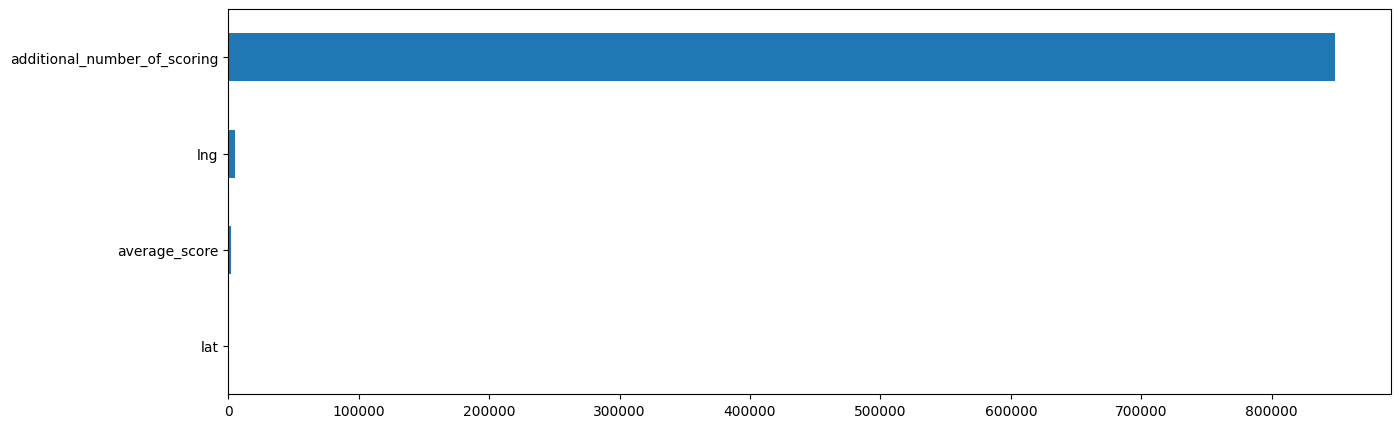

In [160]:
# Категориальные признаки
y1=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y1)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
fig, axes = plt.subplots(1, 1, figsize=(15, 5 ))  # График динамически настраивается в высоту
imp_cat.plot(kind = 'barh')
imp_cat

<Axes: >

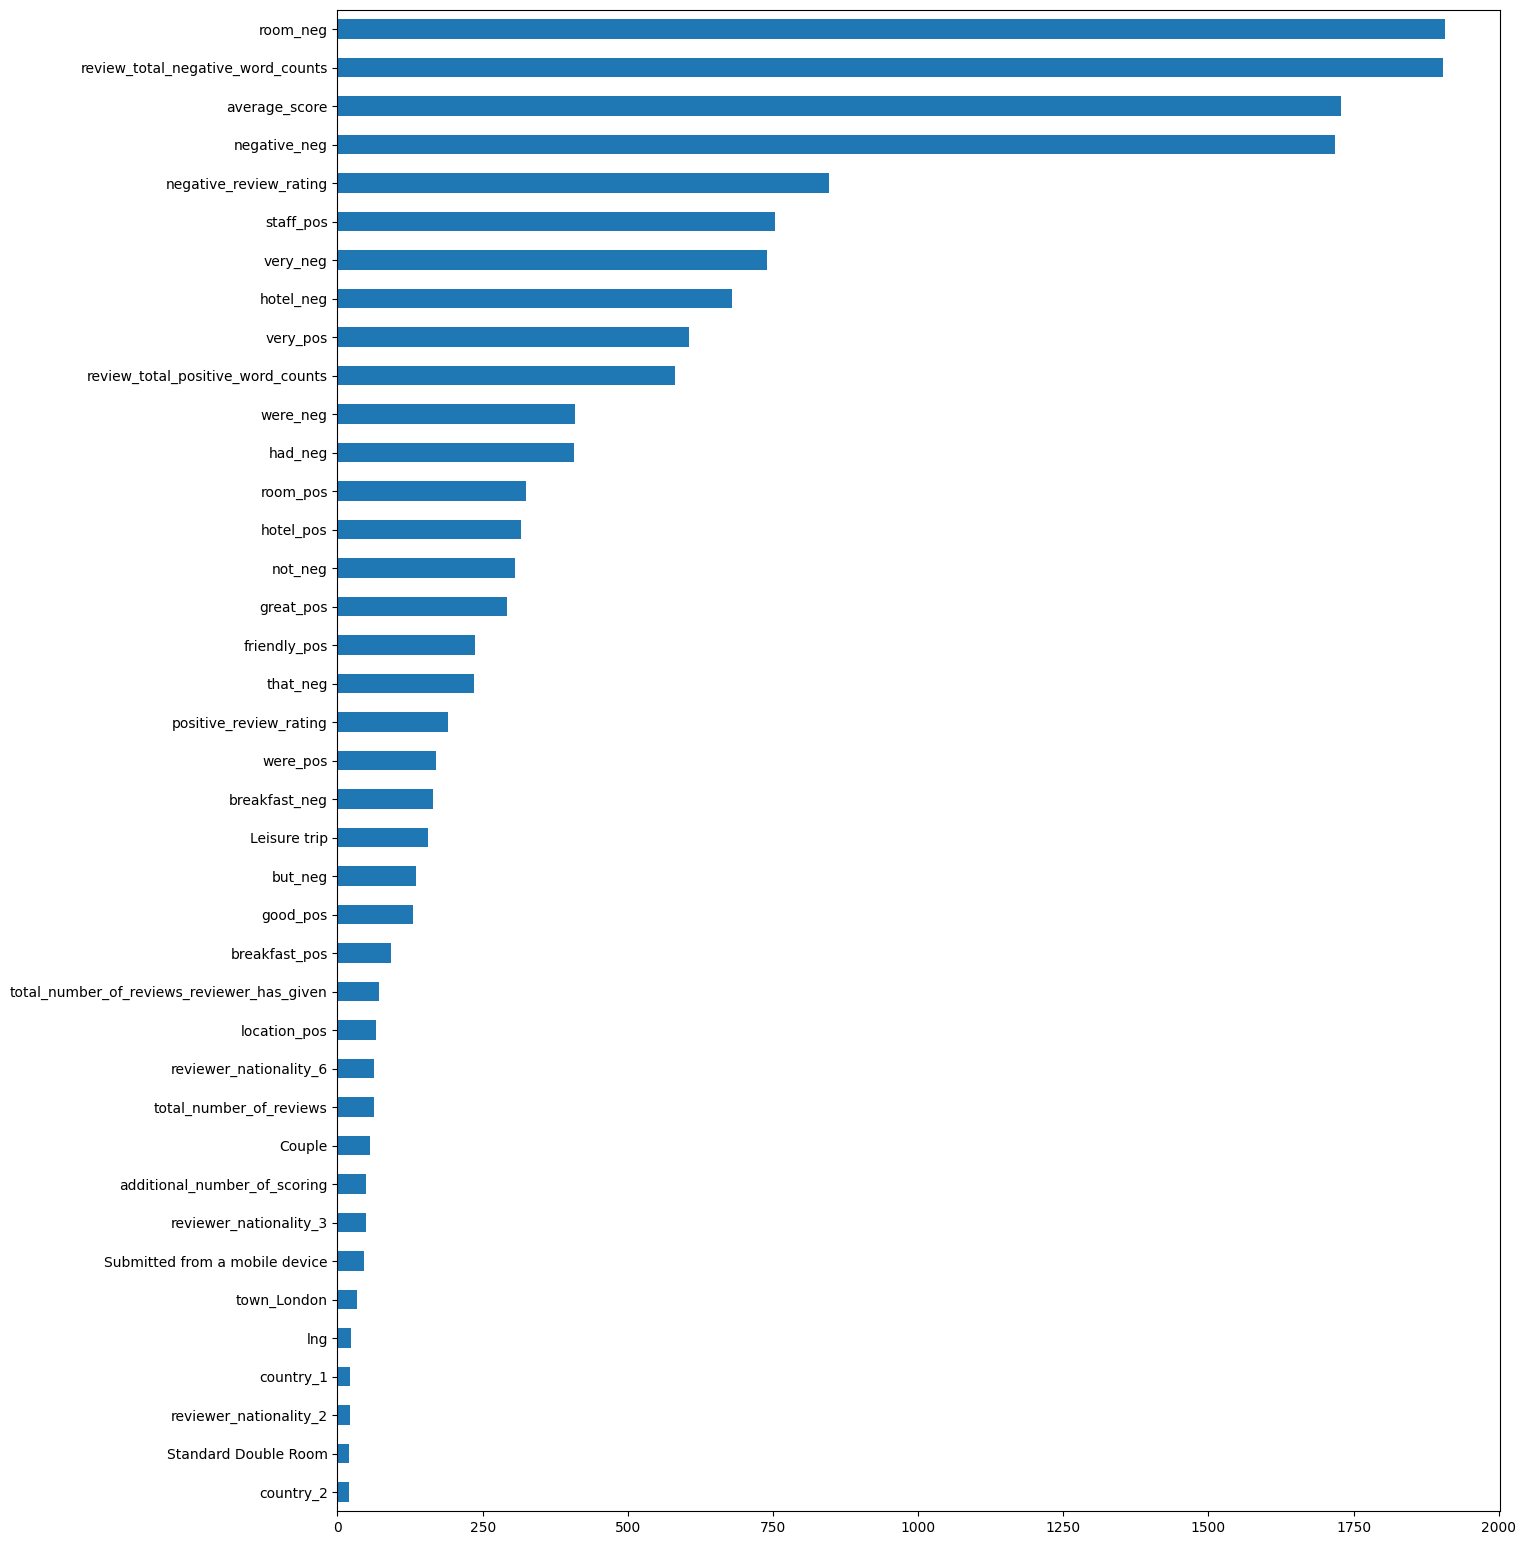

In [ ]:
# Числовые признаки


# Предварительная оценка
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)

# Удалим признаки, которые влия.т меньше, чем на % от максимального значения
imp_num_max = imp_num.max()
del_cols = imp_num[ imp_num < imp_num_max * 0.01].index.to_list()

# Удаляем избытояные для обучения признаки
X_train.drop( del_cols, axis=1, inplace=True )
X_test.drop( del_cols, axis=1, inplace=True )
X.drop( del_cols, axis=1, inplace=True )

# Визуализируем
num_cols = list( set( num_cols ) - set( del_cols ) )

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)

fig, axes = plt.subplots(1, 1, figsize=(15, 5 * X_train.shape[1] / 10))
imp_num.plot(kind = 'barh')

# Обучаем модель

In [166]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

################################################
# default: MAPE: 0.14155421973519144

# 7 min

In [167]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1280573557324177


In [674]:
X_train = pd.concat([X_train, y_train.to_frame().loc[:,'reviewer_score']], ignore_index=True,axis=1)

In [675]:
X_train.to_csv('hotel_submit.csv', index = False)